In [1]:
from nufeb_tools import utils,plot,stats
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist,squareform
from scipy.spatial import KDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
#import skgeom as sg
from tqdm import tqdm
from pathlib import Path
import dask
from dask import dataframe as dd
from joblib import Parallel, delayed
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
BASE_DIR = Path(f'../simulation-data/runs')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
subset = folders[:50]
test_folders = [r'D:\runs\Run_50_50_10_1_2021-07-27',r'D:\runs\Run_50_50_45_1_2021-07-27',r'D:\runs\Run_50_50_100_1_2021-07-27']


# Gather datasets

In [3]:
def collect_data(folder):
    a = utils.get_data(directory=str(folder))
    b = stats.fitness_metrics(a)
    return b

with Parallel(n_jobs=-1) as parallel:
    temp = parallel(delayed(collect_data)(folder) for folder in tqdm(test_folders))
data = pd.concat(temp)

100%|██████████| 3/3 [00:00<00:00, 2989.53it/s]


# Preliminary multiple linear regression

In [36]:
metric2 = data[data.type==2].fillna(0)
import statsmodels.api as sm
metric_list = list(metric2.columns.drop('total biomass'))
y = metric2['total biomass']
def get_stats():
    x = metric2[metric_list]
    results = sm.OLS(y, x).fit()
    print(results.summary())
get_stats()

                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     208.6
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           5.39e-85
Time:                        14:28:35   Log-Likelihood:                -1681.6
No. Observations:                 150   AIC:                             3395.
Df Residuals:                     134   BIC:                             3443.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
mother_cell             

# Plot all possible metrics vs biomass

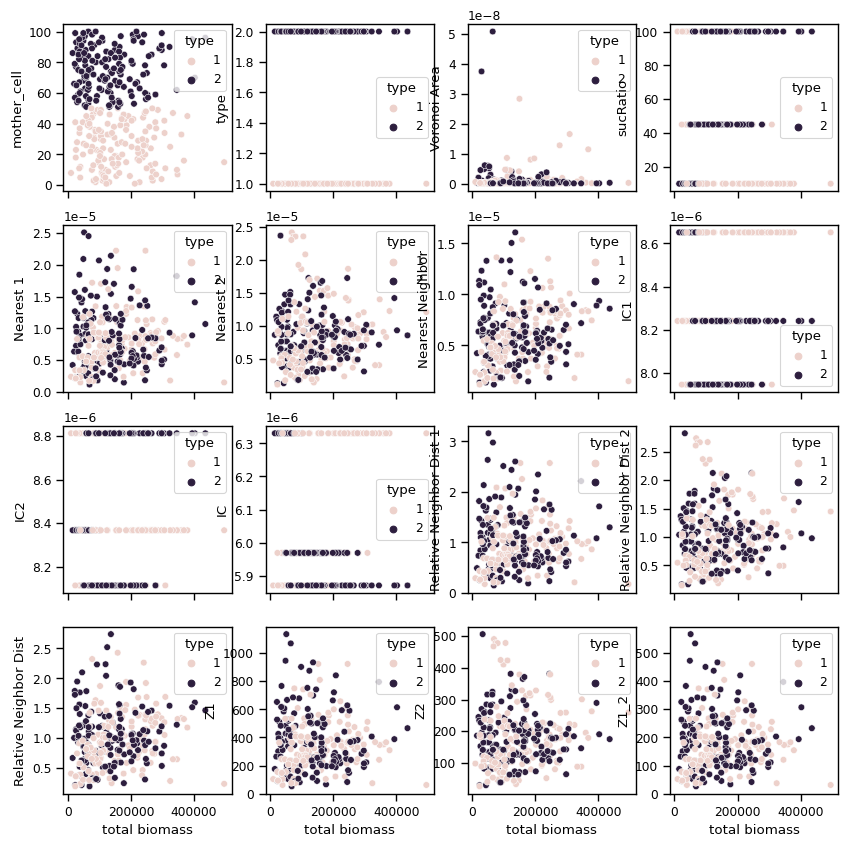

In [44]:

sns.set_context('paper')
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(10,10),sharex=True)
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data,ax=ax)
plt.show()
#for ax in axes.ravel():
   # ax.set_xscale('log')
   # ax.set_yscale('log')


# Define backward regression algorithm

In [64]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y,X[included]).fit()
        pvalues = model.pvalues
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included
threshold = 0.01

# Perform backward regression to find the best fitting parameters

In [22]:
stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets = backward_regression(data[stats], data['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Nearest 1                      with p-value 0.910429
Drop LogNearest 2                   with p-value 0.642901
Drop Log Inv1                       with p-value 0.513598
Drop Relative Neighbor Dist 2       with p-value 0.477057
Drop Relative Neighbor Dist 1       with p-value 0.471555
Drop Z1                             with p-value 0.476823
Drop Z2                             with p-value 0.47453
Drop Voronoi Area                   with p-value 0.470628
Drop Inv2                           with p-value 0.362126
Drop mother_cell                    with p-value 0.161033
Drop Z2_1                           with p-value 0.172883
Drop Inv1                           with p-value 0.0919161
Drop sucRatio                       with p-value 0.308425
Drop LogNearest 1                   with p-value 0.168501
Drop Z1_2                           with p-value 0.250141
Drop IC1                            with p-value 0.172183
Drop IC2                            with p-value 0.35296


['type',
 'Nearest 2',
 'Nearest Neighbor',
 'IC',
 'Relative Neighbor Dist',
 'Log Inv2']

# Check the resulting fit

In [46]:
y = data['total biomass']
X = data[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.756
Model:                            OLS   Adj. R-squared (uncentered):              0.751
Method:                 Least Squares   F-statistic:                              152.0
Date:                Wed, 15 Sep 2021   Prob (F-statistic):                    5.07e-87
Time:                        14:43:40   Log-Likelihood:                         -3833.3
No. Observations:                 300   AIC:                                      7679.
Df Residuals:                     294   BIC:                                      7701.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

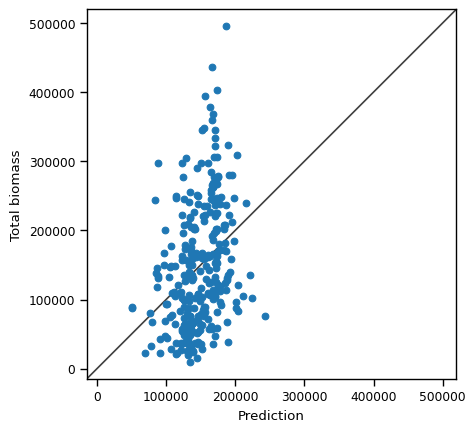

In [48]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

# Regression with scaled metrics

In [50]:

scaler = StandardScaler()
metric_list = list(data.columns.drop(['total biomass','Colony Area']))
to_scale = list(data.columns)
scaled_df = data.copy()
scaled_df[to_scale] = scaler.fit_transform(data[to_scale])
scaled_df

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z2,Z1_2,Z2_1,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area,LogNearest 1,LogNearest 2
0,1.506960,1.0,1.116751,-1.124803,-1.089382,0.454818,-0.173839,0.581860,1.285932,-0.221479,...,-0.161605,0.355247,-0.161605,-0.592832,-0.263363,-0.640545,-0.075281,-0.378740,0.640545,0.075281
1,0.051964,1.0,0.924663,-1.124803,-1.047064,-1.028768,-0.173839,-0.835481,1.285932,-0.221479,...,-0.161605,-1.064878,-0.161605,0.838399,-0.263363,1.131424,-0.075281,-0.466784,-1.131424,0.075281
2,0.606248,1.0,-0.237720,-1.124803,-1.090453,0.760562,-0.503257,0.075842,1.285932,-0.221479,...,-0.496507,0.647913,-0.496507,-0.687011,-0.001142,-0.855782,0.301095,-0.586098,0.855782,-0.301095
3,0.433034,1.0,-0.242983,-1.124803,-1.032568,0.187567,-0.503257,0.075842,1.285932,-0.221479,...,-0.496507,0.099428,-0.496507,-0.487563,-0.001142,-0.427792,0.301095,-0.580822,0.427792,-0.301095
4,0.294463,1.0,-0.191492,-1.124803,-1.276131,0.283260,-0.593353,-0.062555,1.285932,-0.221479,...,-0.588103,0.191027,-0.588103,-0.528262,0.092553,-0.506993,0.418937,-0.955034,0.506993,-0.418937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.640891,1.0,-0.237907,1.304772,0.528067,-0.855452,0.060141,-0.560853,-0.133275,1.320372,...,-0.027581,-0.850822,-0.027581,0.454859,-0.397731,0.804667,-0.302595,0.917445,-0.804667,0.302595
96,1.576245,1.0,-0.201811,1.304772,3.170099,0.544854,0.039949,0.910259,-0.133275,1.320372,...,-0.047072,0.556173,-0.047072,-0.623045,-0.387373,-0.706739,-0.284043,3.141856,0.706739,0.284043
97,0.675534,1.0,-0.238924,1.304772,2.803630,1.314165,0.216407,1.181315,-0.133275,1.320372,...,0.123262,1.329158,0.123262,-0.811488,-0.471396,-1.188458,-0.440197,3.722596,1.188458,0.440197
98,1.403031,1.0,-0.240642,1.304772,1.643306,-0.282113,0.216407,0.347632,-0.133275,1.320372,...,0.123262,-0.274745,0.123262,-0.216598,-0.471396,0.023730,-0.440197,1.980962,-0.023730,0.440197


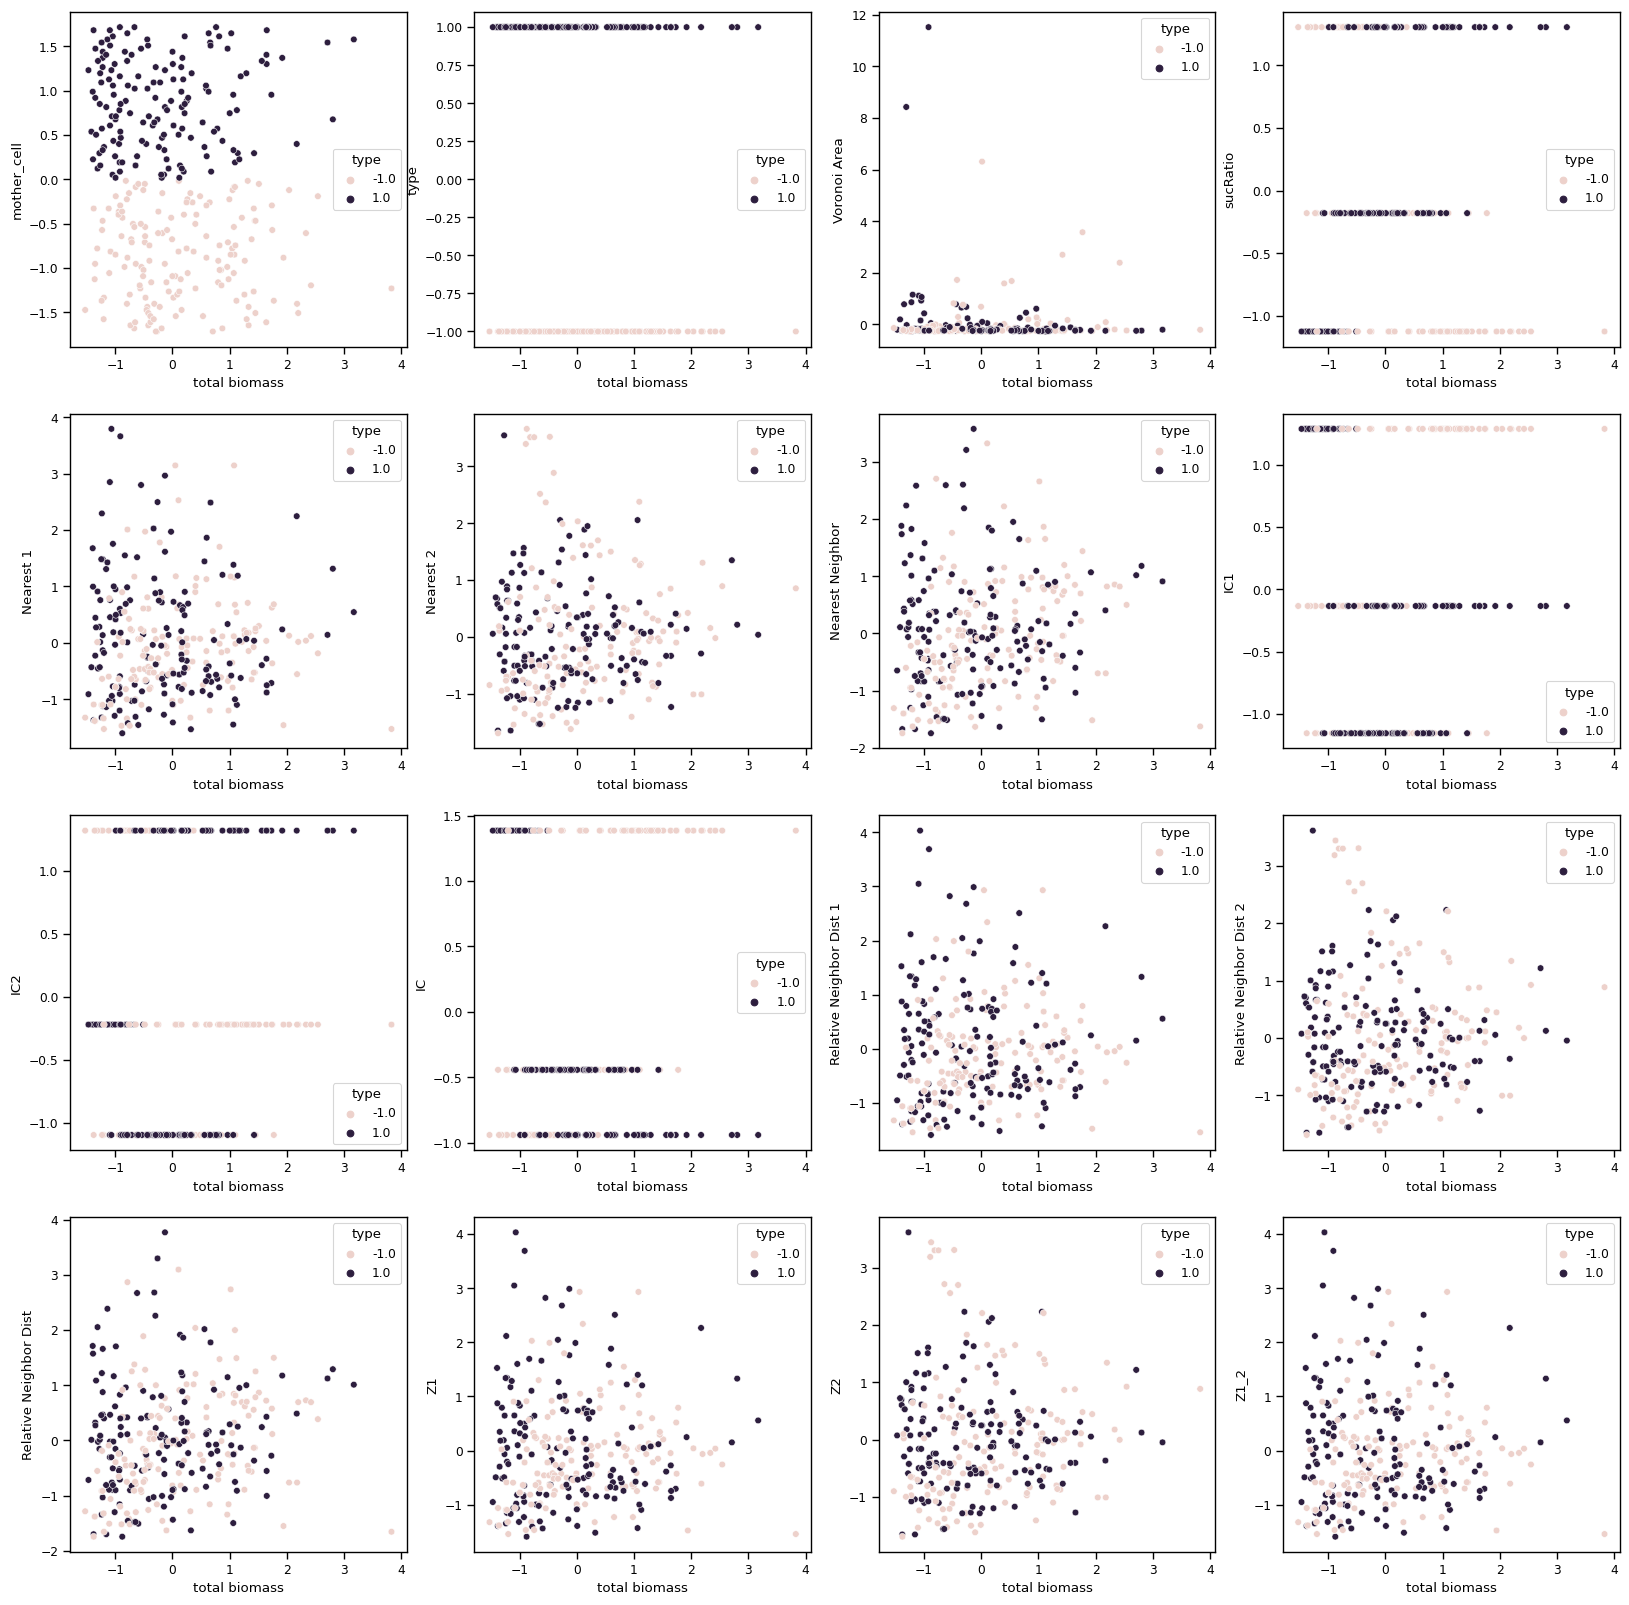

In [51]:
f, axes = plt.subplots(nrows = int(np.sqrt(len(metric_list))),ncols=int(np.sqrt(len(metric_list))),figsize=(20,20))
for met,ax in zip(metric_list,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=scaled_df,ax=ax)
plt.show()

In [52]:
stats = list(data.columns.drop(['total biomass','Colony Area']))
reg_mets = backward_regression(scaled_df[stats], scaled_df['total biomass'], threshold_out=threshold,
                           verbose=True)


Drop Log Inv2                       with p-value 0.992825
Drop Log Inv1                       with p-value 0.9886
Drop Z2_1                           with p-value 0.989957
Drop Relative Neighbor Dist 2       with p-value 0.990434
Drop Z1_2                           with p-value 0.992388
Drop Relative Neighbor Dist 1       with p-value 0.99294
Drop IC2                            with p-value 0.993003
Drop sucRatio                       with p-value 0.991698
Drop Nearest 1                      with p-value 0.910336
Drop IC                             with p-value 0.781119
Drop Voronoi Area                   with p-value 0.475294
Drop Inv2                           with p-value 0.368701
Drop mother_cell                    with p-value 0.162948
Drop Inv1                           with p-value 0.0704521
Drop LogNearest 1                   with p-value 0.157497
Drop Z1                             with p-value 0.270279
Drop Z2                             with p-value 0.0772217
Drop IC1       

In [53]:
y = scaled_df['total biomass']
X = scaled_df[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.093
Model:                            OLS   Adj. R-squared (uncentered):              0.084
Method:                 Least Squares   F-statistic:                              10.11
Date:                Wed, 15 Sep 2021   Prob (F-statistic):                    2.32e-06
Time:                        14:50:31   Log-Likelihood:                         -411.09
No. Observations:                 300   AIC:                                      828.2
Df Residuals:                     297   BIC:                                      839.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

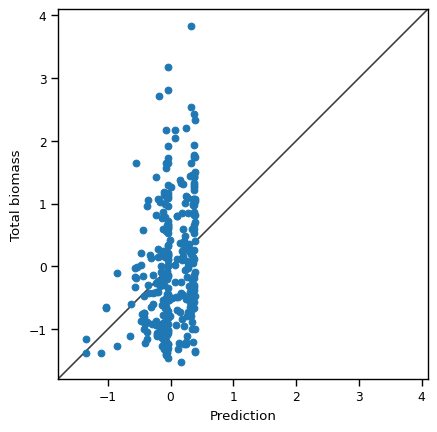

In [54]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

# E. coli analysis

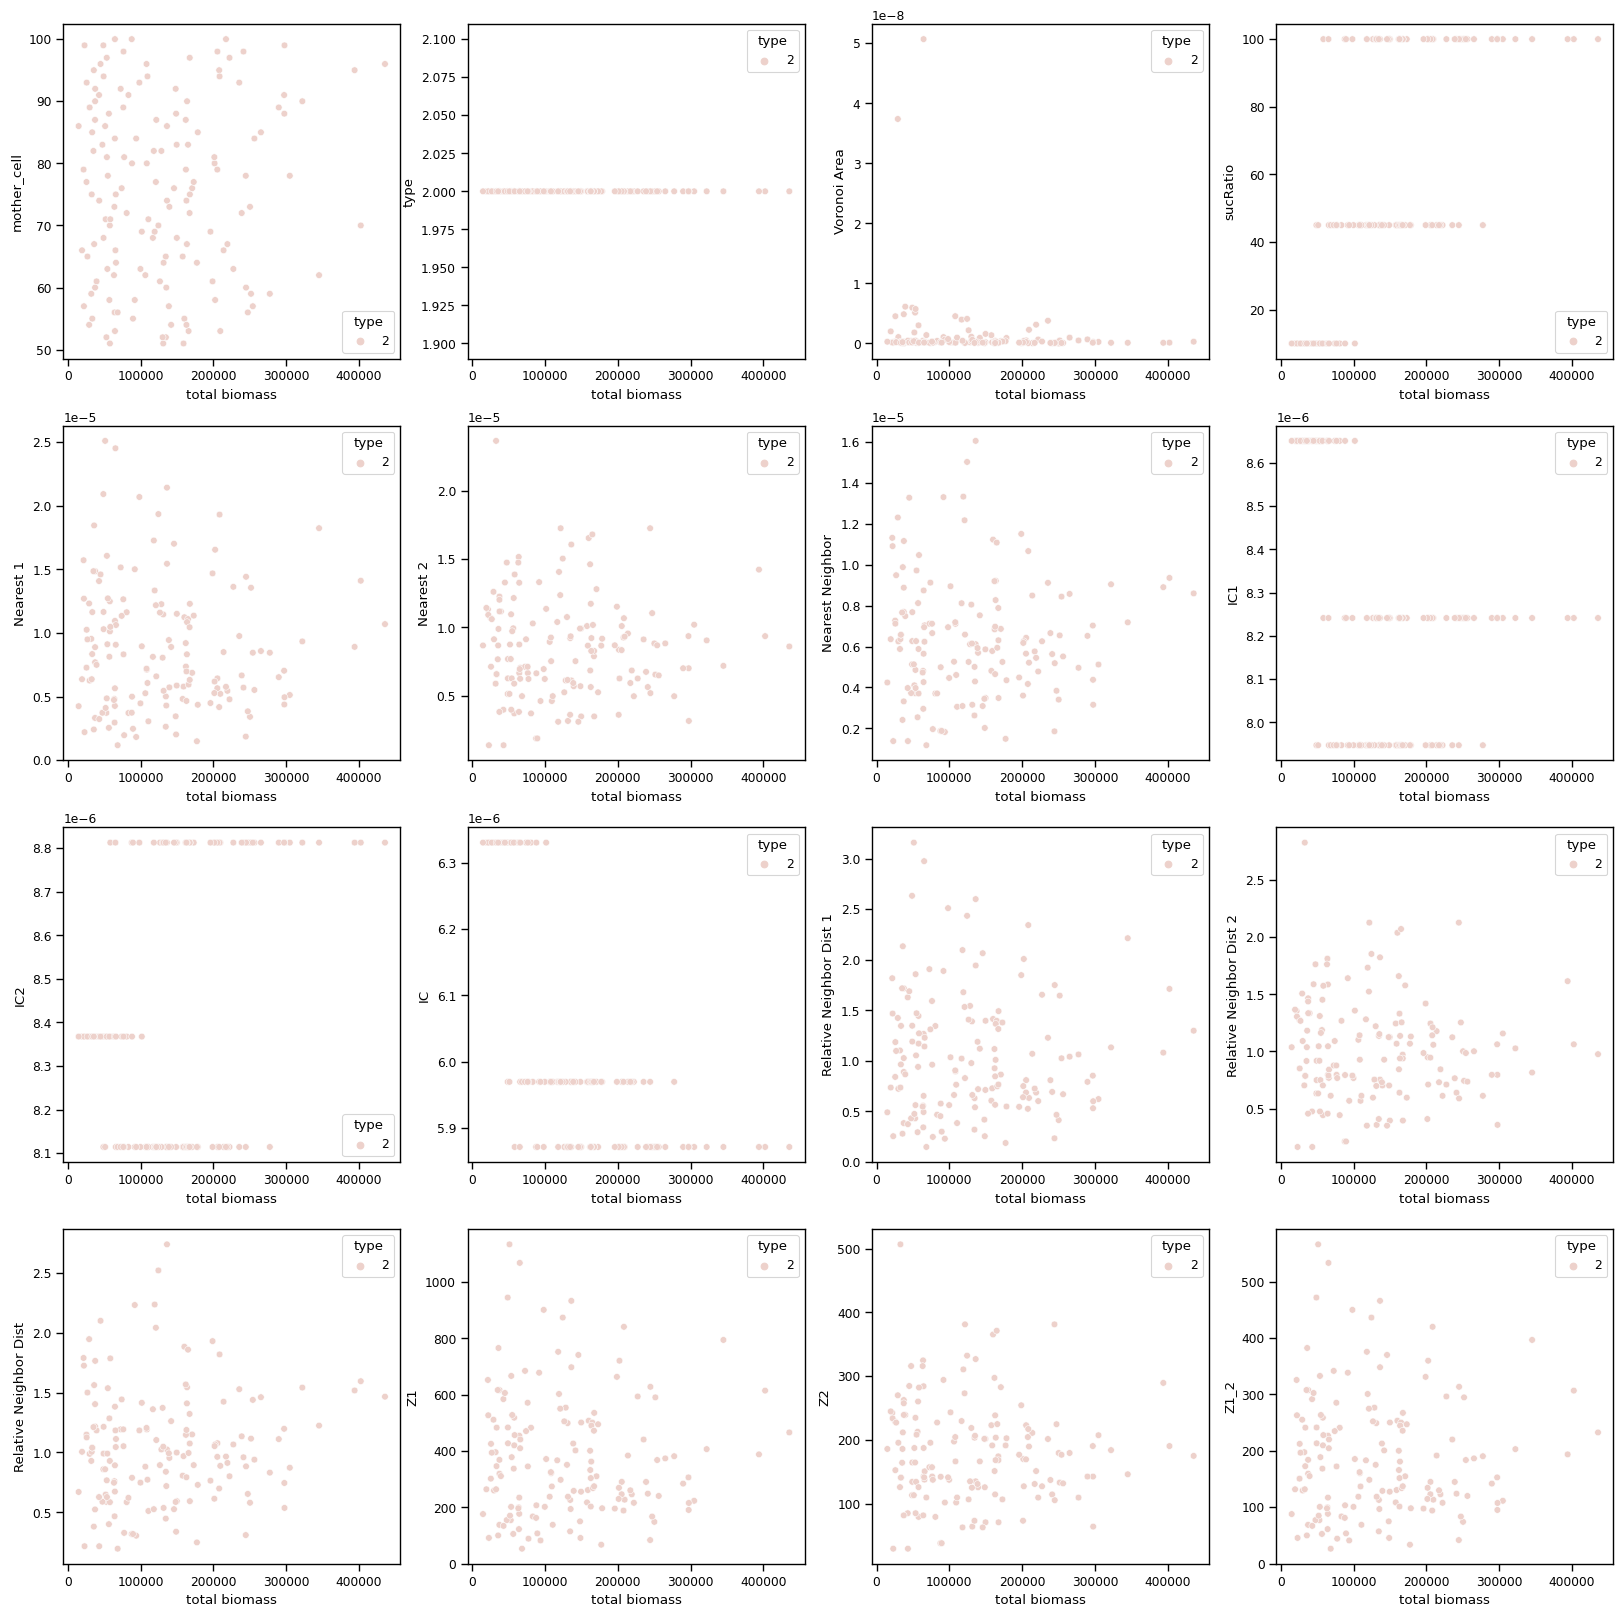

In [62]:
data2 = data[data.type==2]
stats = list(data2.columns.drop(['total biomass','Colony Area']))
f, axes = plt.subplots(nrows = int(np.sqrt(len(stats))),ncols=int(np.sqrt(len(stats))),figsize=(20,20))
for met,ax in zip(stats,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,hue='type',data=data2,ax=ax)
plt.show()

In [65]:
reg_mets = backward_regression(data2[stats], data2['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Z1                             with p-value 0.986081
Drop Z2                             with p-value 0.981704
Drop Relative Neighbor Dist 1       with p-value 0.987364
Drop Relative Neighbor Dist 2       with p-value 0.981817
Drop Voronoi Area                   with p-value 0.981217
Drop IC2                            with p-value 0.611785
Drop IC1                            with p-value 0.611785
Drop IC                             with p-value 0.611785
Drop Inv2                           with p-value 0.574117
Drop Nearest 1                      with p-value 0.305954
Drop Z2_1                           with p-value 0.183911
Drop Inv1                           with p-value 0.109183
Drop mother_cell                    with p-value 0.166267
Drop Log Inv1                       with p-value 0.0422474
Drop LogNearest 1                   with p-value 0.0422418
Drop Nearest 2                      with p-value 0.0125549
Drop LogNearest 2                   with p-value 0.311401
Drop Log In

['type', 'sucRatio', 'Nearest Neighbor', 'Relative Neighbor Dist', 'Z1_2']

In [66]:
y = data2['total biomass']
X = data2[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          total biomass   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     51.88
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           4.66e-27
Time:                        15:00:13   Log-Likelihood:                -1854.4
No. Observations:                 150   AIC:                             3719.
Df Residuals:                     145   BIC:                             3734.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
type                    3.48

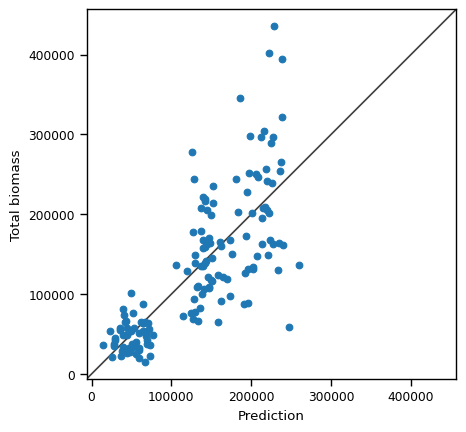

In [67]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

In [68]:
scaled_df2 = data2.copy()
scaled_df2[to_scale] = scaler.fit_transform(data2[to_scale])
scaled_df2

,mother_cell,type,Voronoi Area,sucRatio,total biomass,Nearest 1,Nearest 2,Nearest Neighbor,IC1,IC2,...,Z2,Z1_2,Z2_1,Inv1,Inv2,Log Inv1,Log Inv2,Colony Area,LogNearest 1,LogNearest 2
0,1.281974,0.0,0.906103,-1.124803,-0.943657,0.307501,-0.209268,0.482130,1.285932,-0.221479,...,-0.197580,0.215302,-0.197580,-0.552092,-0.202319,-0.539117,-0.018323,-0.619492,0.539117,0.018323
1,-1.628453,0.0,0.746719,-1.124803,-0.900142,-1.021337,-0.209268,-0.904553,1.285932,-0.221479,...,-0.197580,-1.046715,-0.197580,0.830332,-0.202319,1.121763,-0.018323,-0.704240,-1.121763,0.018323
2,-0.519719,0.0,-0.217760,-1.124803,-0.944759,0.581354,-0.597180,-0.012942,1.285932,-0.221479,...,-0.581473,0.475384,-0.581473,-0.643059,0.088543,-0.740860,0.402316,-0.819088,0.740860,-0.402316
3,-0.866199,0.0,-0.222128,-1.124803,-0.885236,0.068126,-0.597180,-0.012942,1.285932,-0.221479,...,-0.581473,-0.012036,-0.581473,-0.450413,0.088543,-0.339702,0.402316,-0.814009,0.339702,-0.402316
4,-1.143382,0.0,-0.179403,-1.124803,-1.135687,0.153838,-0.703274,-0.148345,1.285932,-0.221479,...,-0.686468,0.069365,-0.686468,-0.489724,0.192472,-0.413937,0.534018,-1.174214,0.413937,-0.534018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.450423,0.0,-0.217916,1.304772,0.719537,-0.866099,0.066259,-0.635865,-0.133275,1.320372,...,-0.043950,-0.856491,-0.043950,0.459871,-0.351363,0.815491,-0.272370,0.628173,-0.815491,0.272370
96,1.420566,0.0,-0.187966,1.304772,3.436289,0.388146,0.042482,0.803426,-0.133275,1.320372,...,-0.066293,0.393858,-0.066293,-0.581275,-0.339874,-0.601161,-0.251637,2.769319,0.601161,0.251637
97,-0.381127,0.0,-0.218759,1.304772,3.059456,1.077213,0.250272,1.068619,-0.133275,1.320372,...,0.128959,1.080783,0.128959,-0.763292,-0.433074,-1.052680,-0.426156,3.328320,1.052680,0.426156
98,1.074086,0.0,-0.220185,1.304772,1.866315,-0.352564,0.250272,0.252969,-0.133275,1.320372,...,0.128959,-0.344551,0.128959,-0.188688,-0.433074,0.083513,-0.426156,1.651880,-0.083513,0.426156


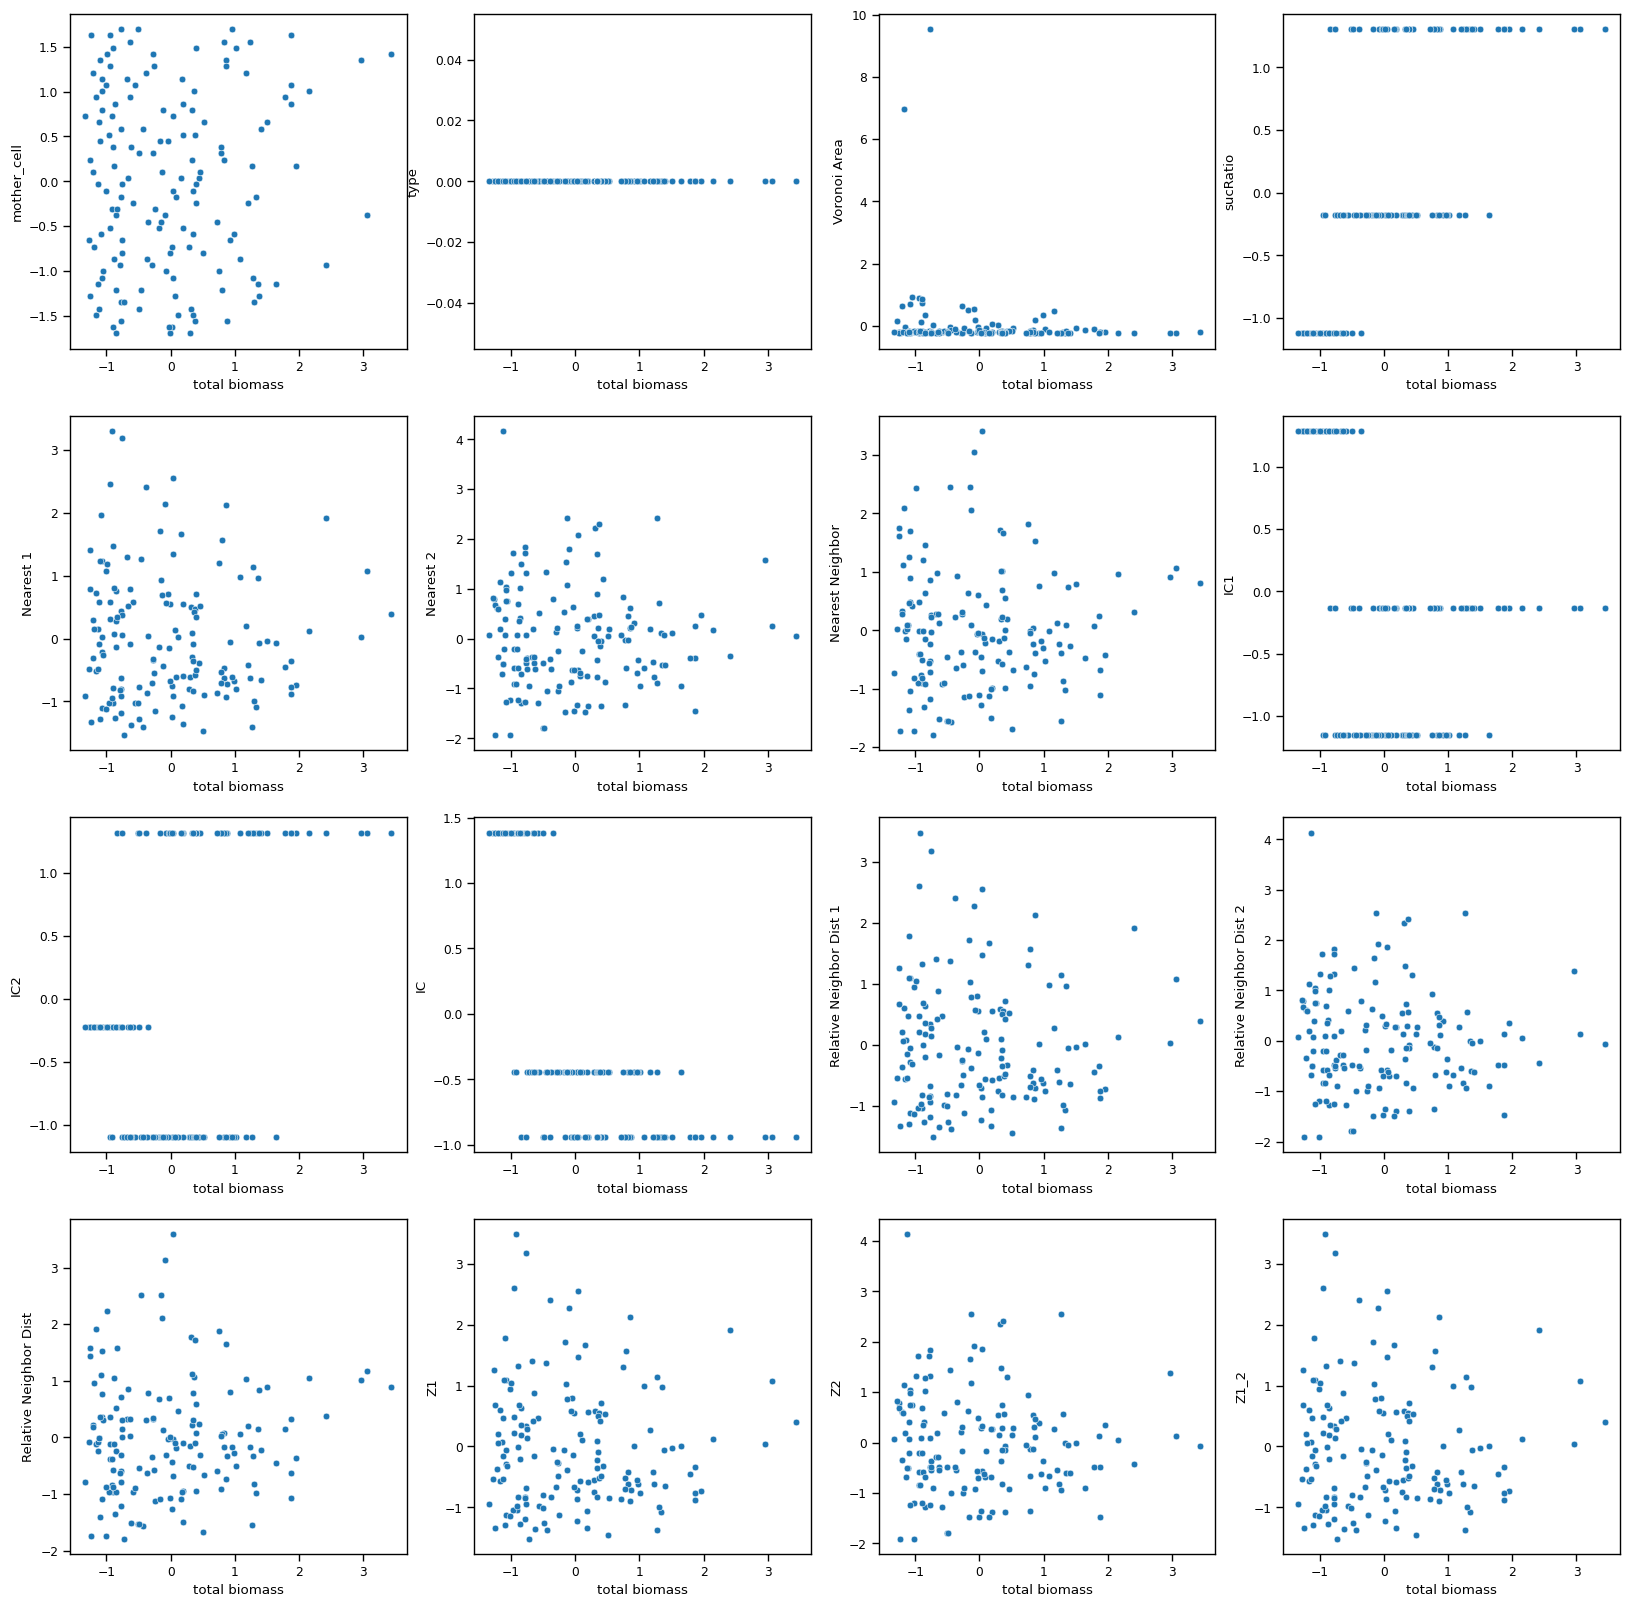

In [70]:
f, axes = plt.subplots(nrows = int(np.sqrt(len(stats))),ncols=int(np.sqrt(len(stats))),figsize=(20,20))
for met,ax in zip(stats,axes.ravel()):
   sns.scatterplot(x='total biomass',y=met,data=scaled_df2,ax=ax)
plt.show()

In [71]:
reg_mets = backward_regression(scaled_df2[stats], scaled_df2['total biomass'], threshold_out=threshold,
                           verbose=True)
reg_mets

Drop Voronoi Area                   with p-value 0.981123
Drop type                           with p-value 0.701731
Drop Inv2                           with p-value 0.56139
Drop Z2                             with p-value 0.416167
Drop Z2_1                           with p-value 0.416167
Drop Relative Neighbor Dist 2       with p-value 0.416167
Drop Inv1                           with p-value 0.321113
Drop IC2                            with p-value 0.210053
Drop IC1                            with p-value 0.257279
Drop sucRatio                       with p-value 0.623783
Drop Nearest 2                      with p-value 0.121193
Drop LogNearest 2                   with p-value 0.148685
Drop Log Inv2                       with p-value 0.148685
Drop mother_cell                    with p-value 0.138995
Drop Log Inv1                       with p-value 0.0135615
Drop LogNearest 1                   with p-value 0.0135615


['Nearest 1',
 'Nearest Neighbor',
 'IC',
 'Relative Neighbor Dist 1',
 'Relative Neighbor Dist',
 'Z1',
 'Z1_2']

In [72]:
y = scaled_df2['total biomass']
X = scaled_df2[reg_mets]
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          total biomass   R-squared (uncentered):                   0.601
Model:                            OLS   Adj. R-squared (uncentered):              0.588
Method:                 Least Squares   F-statistic:                              43.73
Date:                Wed, 15 Sep 2021   Prob (F-statistic):                    2.52e-27
Time:                        15:06:04   Log-Likelihood:                         -143.88
No. Observations:                 150   AIC:                                      297.8
Df Residuals:                     145   BIC:                                      312.8
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

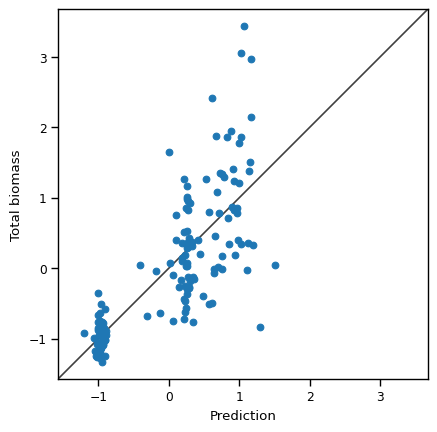

In [73]:
f, ax = plt.subplots()

ax.scatter(predictions,y)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Prediction')
ax.set_ylabel('Total biomass')
plt.show()

In [57]:
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
names=pd.DataFrame(X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 3, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] ==1] 
print(most_important)

most_important['Rank'].count()

        Feature  Rank
0          type     1
1     Nearest 2     1
2  LogNearest 2     1


C:\Users\Jonathan\anaconda3\envs\pyscaffold\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


3

In [58]:
lin_reg.fit(X,y)
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)

Intercept: 
 1.2911592068651143e-15
Coefficients: 
 [-0.20960854 -0.59589566  0.68331358]
